# DEM Analysis
In this notebook DEM features are extracted and analyzed whether they stand in some relation to the clusters that were found in our AOI.

In [1]:
import sys
sys.path.append("./notebooks")
sys.path.append("../src")


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from data_processing.dem_processor import DEMProcessor
from scipy.stats import kruskal
from sklearn.preprocessing import RobustScaler
from mord import LogisticAT

## DEM-Feature Workflow

In [2]:
dp = DEMProcessor()

11:28:50.516101: [INFO] DEM_PROCESSOR Initializing DEM Processor

11:28:50.516298: [INFO] DATA_PROCESSING Initializing GeometryProcessor with data file: dataMonthly.npy



In [3]:
dem_feature_df = dp.extract_features_as_df()
dem_feature_df

height  slope_deg  aspect_deg     northness      eastness       tpi  \
0        843.0   5.710593  180.000000 -1.000000e+00 -1.224647e-16 -7.329861   
1        843.0   6.017285  198.434949 -9.486833e-01 -3.162278e-01 -7.572917   
2        845.0   8.104436  200.556045 -9.363292e-01 -3.511234e-01 -6.065972   
3        846.0   7.825526  194.036243 -9.701425e-01 -2.425356e-01 -5.736111   
4        847.0   6.379370  206.565051 -8.944272e-01 -4.472136e-01 -5.545139   
...        ...        ...         ...           ...           ...       ...   
664443   642.0   6.017285   71.565051  3.162278e-01  9.486833e-01  6.996528   
664444   640.0   3.814075   90.000000  6.123234e-17  1.000000e+00  6.281250   
664445   638.0   3.814075   90.000000  6.123234e-17  1.000000e+00  5.145833   
664446   636.0   3.438912   56.309932  5.547002e-01  8.320503e-01  3.673611   
664447   635.0   4.262693   26.565051  8.944272e-01  4.472136e-01  2.972222   

             twi     uca   log_uca  distance_to_stream  label  
0       5.703773   900.0  2.954243           90.000000    2.0  
1       5.651093   900.0  2.954243           94.868330    2.0  
2       5.350305   900.0  2.954243          108.166538    2.0  
3       5.385781   900.0  2.954243          127.279221    2.0  
4       5.592202   900.0  2.954243          150.000000    2.0  
...          ...     ...       ...                 ...    ...  
664443  7.037387  3600.0  3.556303          789.176786    1.0  
664444  7.718671  4500.0  3.653213          785.175140    1.0  
664445  7.900992  5400.0  3.732394          782.304289    1.0  
664446  6.213051   900.0  2.954243          780.576710    1.0  
664447  5.997662   900.0  2.954243          780.000000    1.0  

[664448 rows x 11 columns]

In [4]:
dem_feature_df["uca"].quantile(0.975)

np.float64(310500.0)

The stream threshold was set at the 97.5th percentile of upstream contributing area (UCA), meaning only pixels with exceptionally high flow accumulation are classified as streams. This places the stream density at approximately 2.5% of all pixels, consistent with the commonly recommended range of 1–5% for hydrological terrain analysis. The threshold was validated visually by overlaying the resulting stream network on the DEM. Lower values produced noisy, fragmented networks while higher values yielded overly sparse results.

## Visualizations of DEM Features

In [5]:
#Visualization settings

dem_features = {
    'height': {
        'vmin': None, 'vmax': None, 'title': "Height", 'cmap': 'cividis',
    },
    'slope_deg': {
        'vmin': None, 'vmax': None, 'title': "Slope Angle in Degree", 'cmap': 'viridis',
    },
    'aspect_deg': {
        'vmin': None, 'vmax': None, 'title': "Aspect Angle in Degree", 'cmap': 'twilight',
    },
    'northness': {
        'vmin': None, 'vmax': None, 'title': "Northness of Aspect", 'cmap': 'RdBu',
    },
    'eastness': {
        'vmin': None, 'vmax': None, 'title': "Eastness of Aspect", 'cmap': 'RdBu',
    },
    'tpi': {
        'vmin': None, 'vmax': None, 'title': "Topographic Position Index (Radius 250m)", 'cmap': 'RdYlGn',
    },
    'twi': {
        'vmin': None, 'vmax': None, 'title': "Topographic Wetness Index", 'cmap': 'viridis',
    },
    'uca': {
        'vmin': None, 'vmax': 1e6, 'title': "Upstream Contributing Area", 'cmap': 'viridis',
    },
    'log_uca': {
        'vmin': None, 'vmax': None, 'title': "Upstream Contributing Area Log10", 'cmap': 'viridis',
    },
    'distance_to_stream': {
        'vmin': None, 'vmax': None, 'title': "Distance to the next stream", 'cmap': 'plasma',
    },
    'label': {
        'vmin': None, 'vmax': None, 'title': "Cluster label", 'cmap': 'viridis',
    },
}

In [6]:
features = list(dem_features.keys())
features.remove("label")

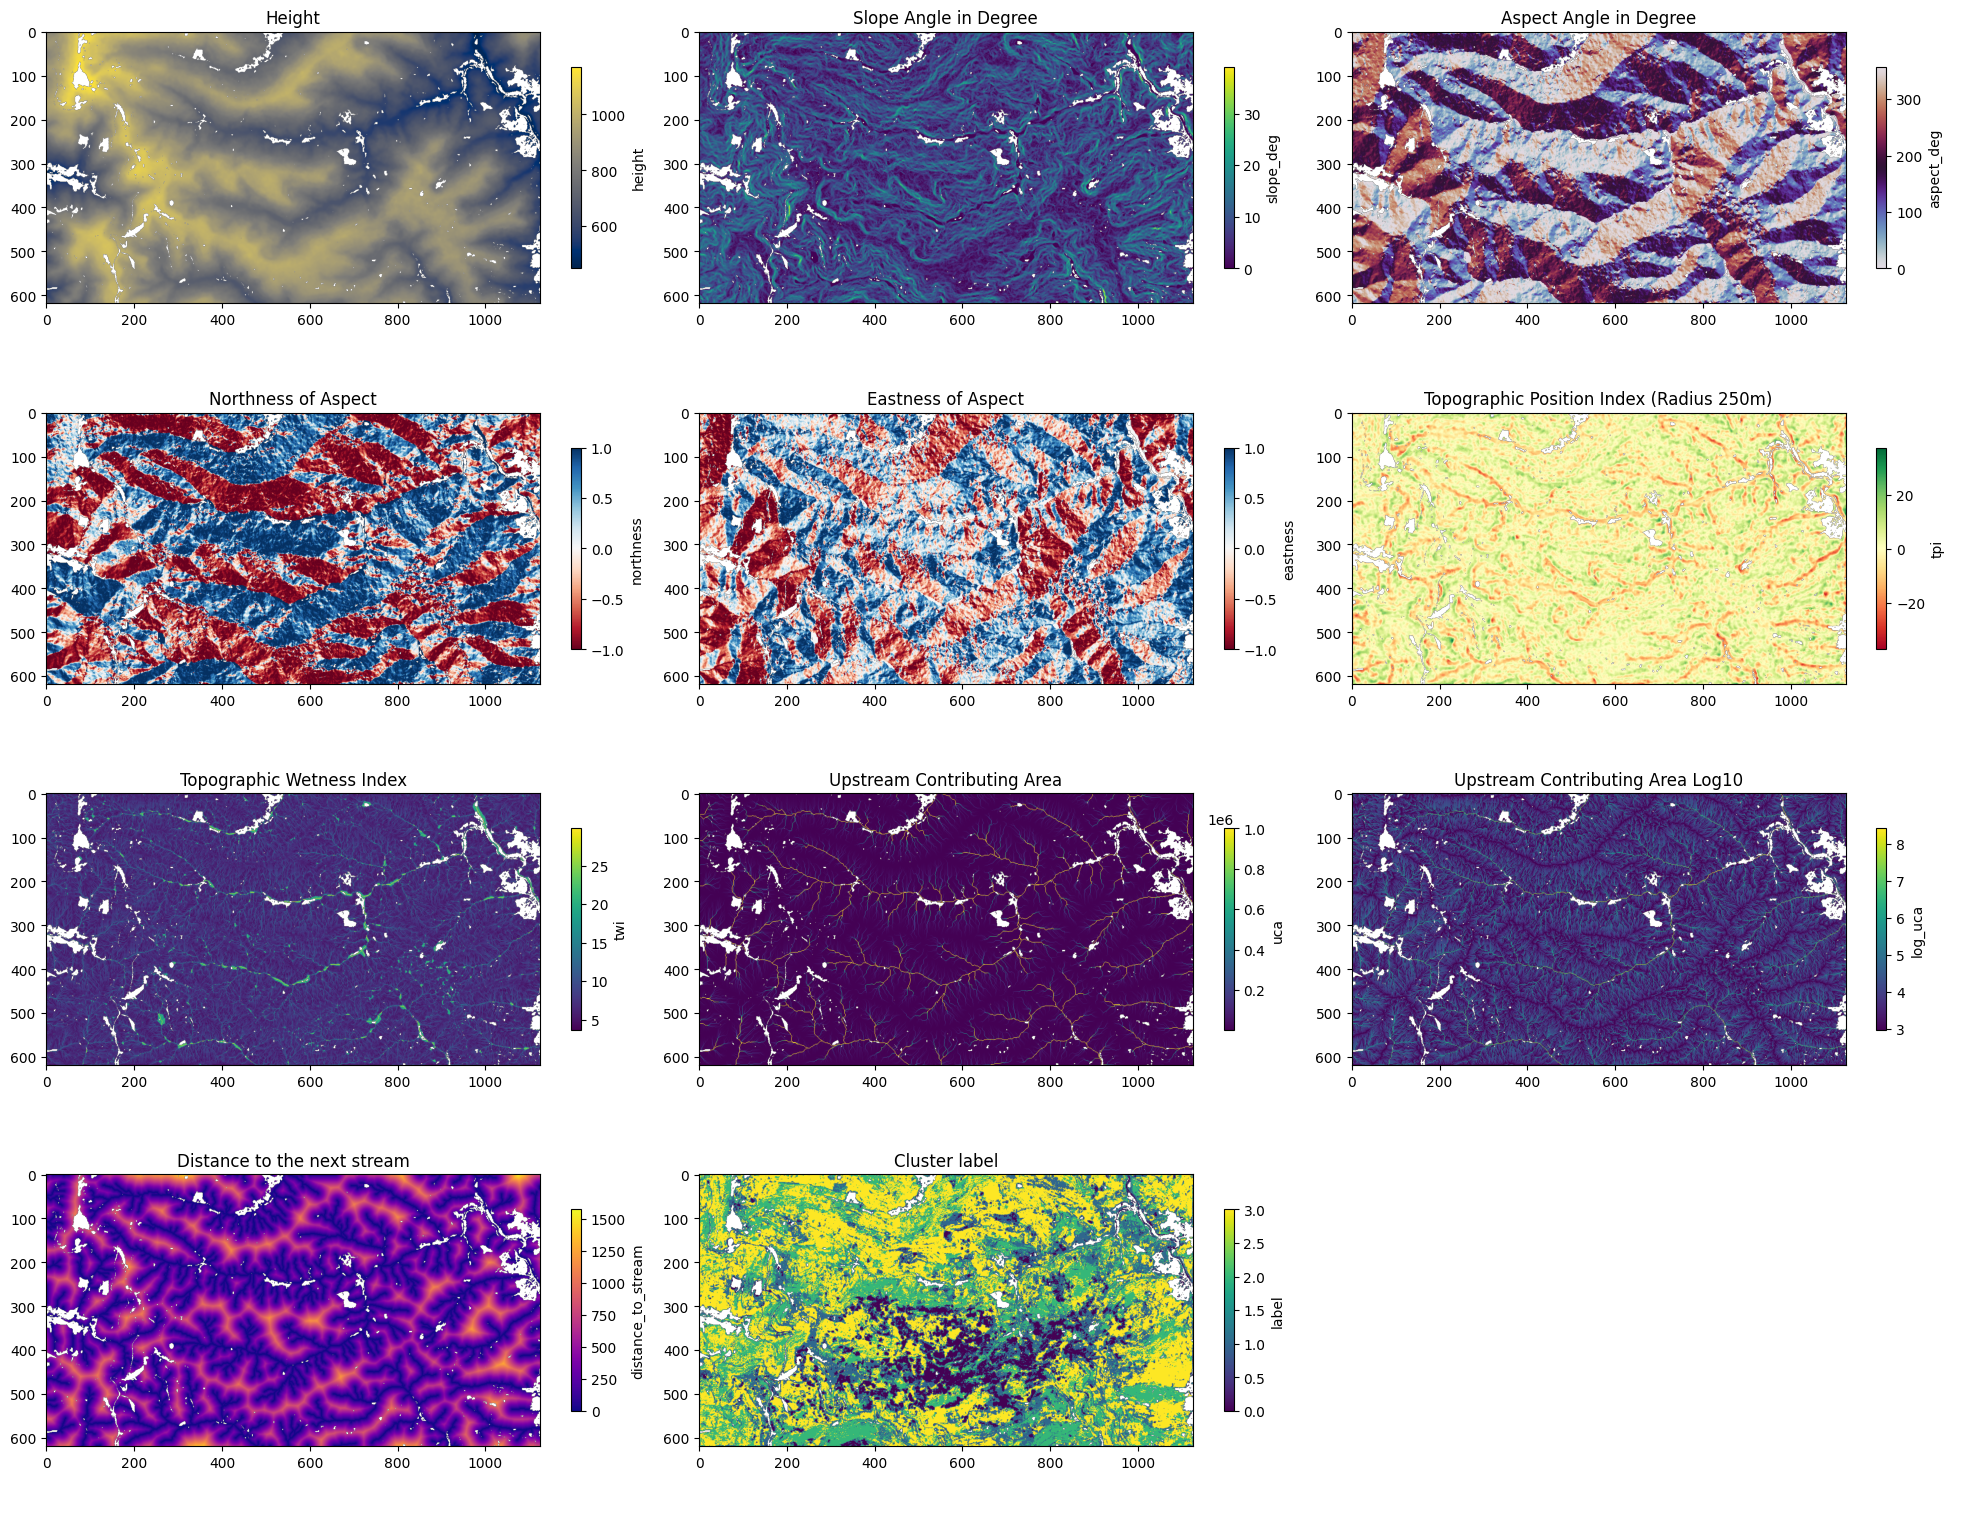

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16))

for feature, ax in zip(dem_features.keys(), axes.flatten()):

    data_2d = dp.geometry_processor.reconstruct_2d(dem_feature_df[feature])

    im = ax.imshow(data_2d, 
                   cmap=dem_features[feature]["cmap"], 
                   vmin=dem_features[feature]["vmin"], 
                   vmax=dem_features[feature]["vmax"])
    
    ax.set_title(dem_features[feature]["title"])

    cbar = fig.colorbar(im, ax=ax, shrink=0.5)
    cbar.set_label(feature)

    plt.tight_layout()
    
axes[3, 2].set_axis_off()

In [8]:
dp.geometry_processor.reconstruct_2d(dem_feature_df["northness"])[450, 600]

np.float64(0.7071067811865476)

##### The Features:

* **Height**: represents the elevation above sea level in meters. The study area spans roughly 500-1100m, with higher values concentrated in the northwestern region around the Hornisgrinde and valley structures clearly visible going longitudinal.
* **Slope Angle**: The angle of the slope of the pixels in degree. Over the study area the slope angles are mostly structured in similar ways between 0° and 20° with some spots near valleys reaching even >35°. The tops of mountain ranges tend to be more flat than the rest of the AOI.
* **Aspect Angle**: The angle of the aspect (direction) in degree. Clearly visualizes the mountain ranges and valleys showing which areas have which sunlight exposure, with mostly either south or north orientated mountain faces.
* **Northness**: Indicates how northern the aspect of that pixel is, representing a component of the aspect. High values represent a northern orientation and with low sunlight exposure. Low values indicate a southern orientation and thus high sunlight exposure during the mid of a day. The values are really high on either end of the spectrum across the whole study area, which reinforces the impression that the mountain ranges mostly run east-west.
* **Eastness**: Indicates how eastern the aspect of that pixel is, representing a component of the aspect. High values indicate an eastern orientation, with sunlight in the morning, low values represent a western orientation and with that high sunlight exposure during the afternoon and evening. In contrast to the Northness, it is visible that mostly in the western part around the Hornisgrinde, there are large areas with high and low eastness values, while in the rest of the AOI the values are much more often closer to zero and areas with high values are much smaller.
* **Topographic Position Index (TPI)**: Indicates how high a pixel is in relation to its neighbours. In this case all the pixel in a 250 meter radius are considered neighbours. This feature follows closely the valleys and ridges represented through the height measure.
* **Topographic Wetness Index (TWI)**: Indicates how much humidity is available at a pixel, using the steepness and water accumulation in that area. This visualization shows wide areas with high values in the valleys with smaller streams splitting up, the higher they go up a ridge all across the AOI.
* **Upstream Contributing Area (UCA) (untransformed & log10)**: Shows how much area is dispersing its water through that pixel, to get a feel for where creeks and streams might be. Shows forking streams, just like the TWI but with more clear streams rather than wide bands flowing through the valleys. The log transformed UCA is visualizing the values much better as the extremely high values get reduced so that the range of the colorbar is not getting as stretched.
* **Distance to the next Stream**: Euclidean distance to the next "stream", which are pixels having a UCA above 300,000m². This shows kind of a inversion of the UCA-Map with high values being at ridge tops and low values being all around the streams in the area.
* **Cluster Label**: The label of the clustering for the pixels. Here it is clearly visible that the majority of degraded forest patches are in the southern middle of the AOI.

##### Overlay of Height and Cluster Labels

<img src="../DATA/images/height_overlay.png" alt="height_overlay" width="60%">  

When overlaying the cluster labels (background, greyscale) with elevation (blue *(low)* -> red *(high)* gradient), degradation does not follow a simple altitudinal gradient. Instead, it concentrates around two specific mountain ridges and an adjacent valley, suggesting that geographic position and local site conditions matter more than elevation alone, which could indicate other factors, like e.g. a bark beetle infestation. More on that on the end of this notebook.

*Image created with QGIS*

#### Features per Cluster

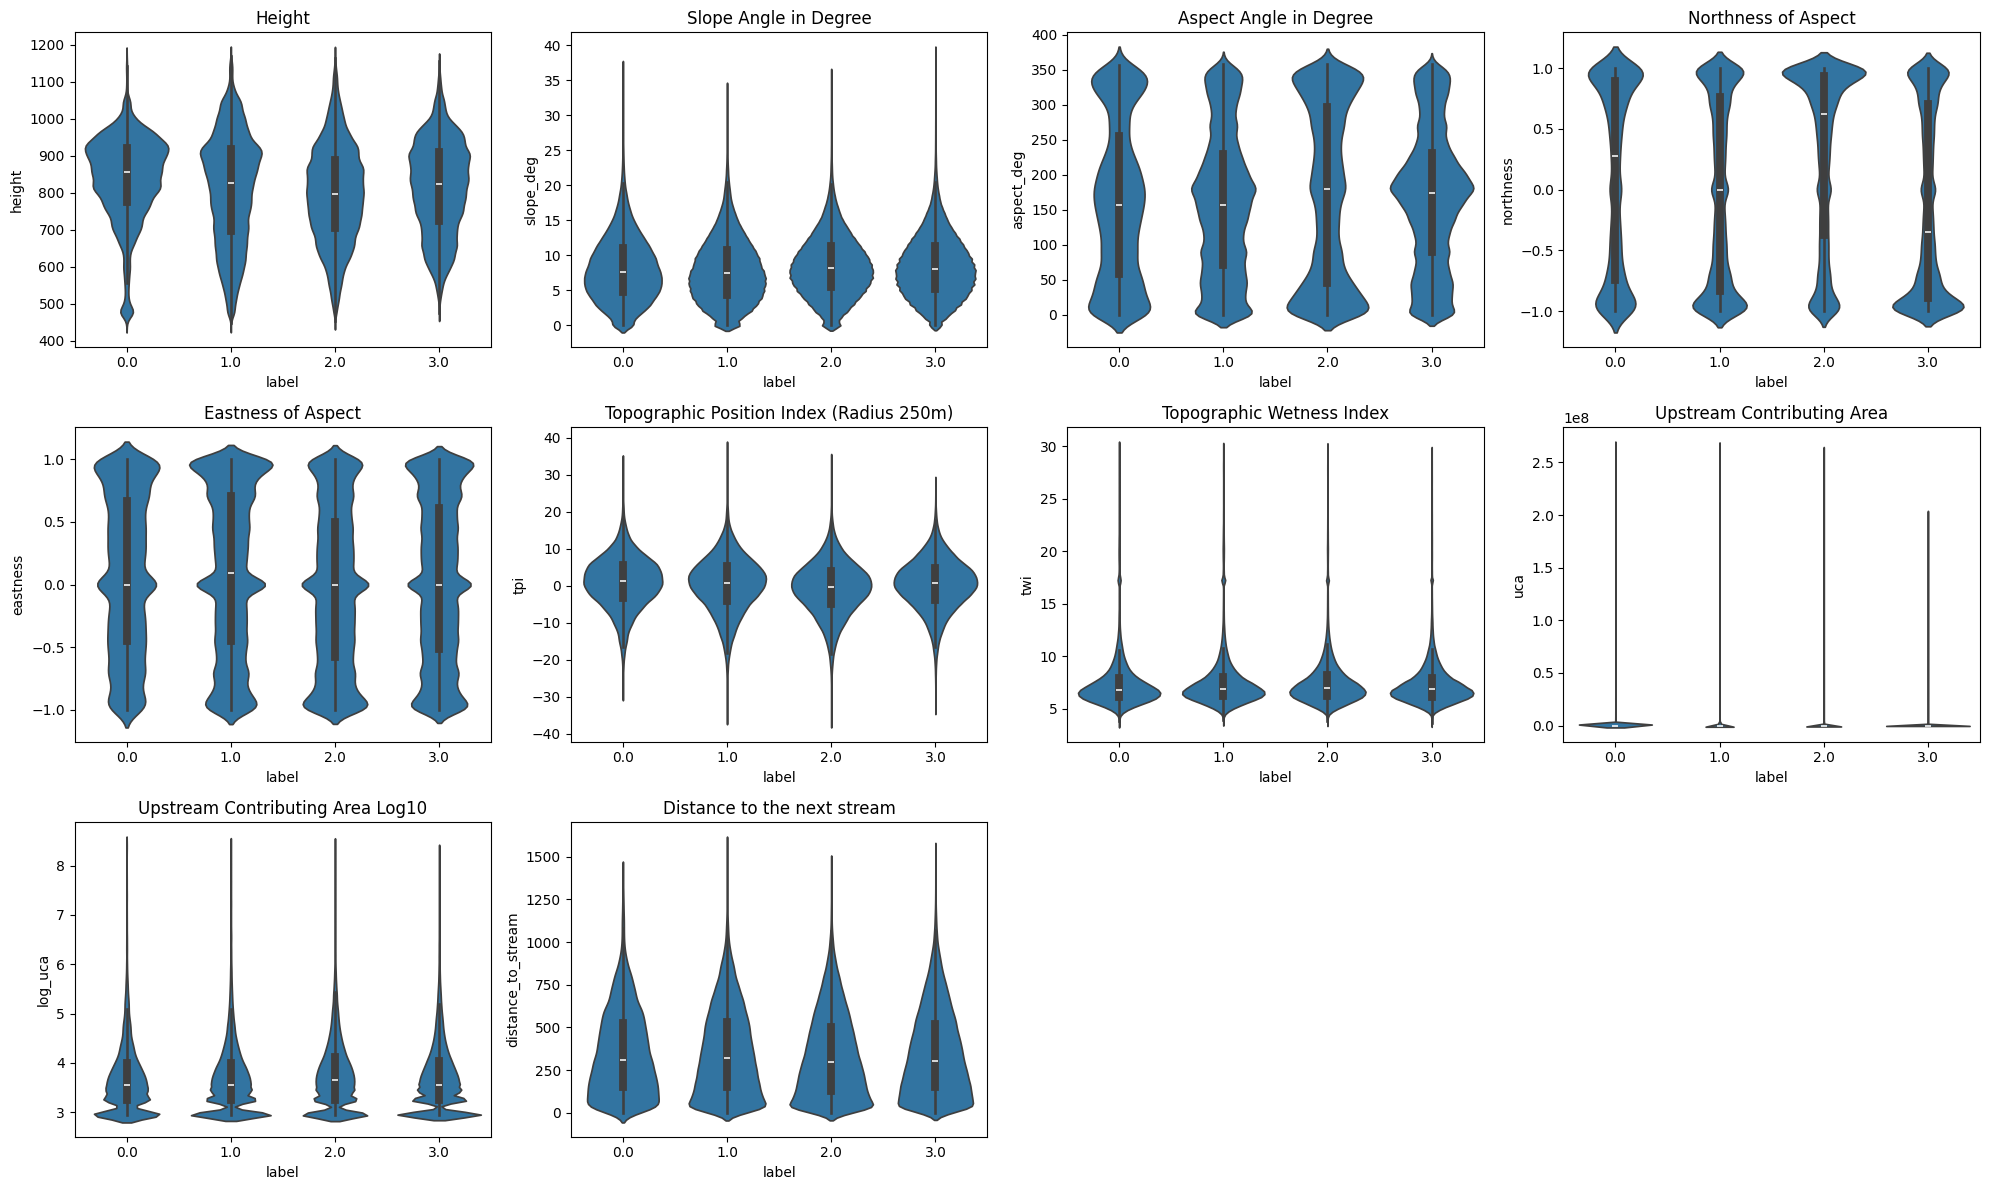

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

for ax, col in zip(axes.flatten(), features):
    sns.violinplot(data=dem_feature_df, x="label", y=col, ax=ax)
    ax.set_title(dem_features[col]["title"])

axes[2, 2].set_axis_off()
axes[2, 3].set_axis_off()

plt.tight_layout()
plt.show()

Most of the features have very similar distributions across all cluster labels, but there are still some patterns and differences.  

The degraded cluster (0) has a much higher density around ~920m of elevation, in addition to the cluster showing a semi-degraded state having a slight density bump at that elevation as-well. This suggests that trees at elevations around that range may be particularly at risk, though no general altitudinal gradient is apparent.  
The biggest differences in those plots is visible when evaluating the aspect and its components. Cluster 2 and 3 have very distinct northness distributions. Cluster 2, previously hypothesized to potentially represent deciduous-dominated areas, shows a notably northern orientation, while Cluster 3 leans southward. If this compositional interpretation holds, it would suggest that in this area deciduous trees preferentially occupy north-facing slopes while south-facing slopes are dominated by evergreen species, but cannot be confirmed without additional species distribution data. 

Slope Angle, TPI, TWI, UCA and Distance to next Stream show no clearly visible differences.

## Statistical Tests

#### Kruskal-Test

In [10]:
results = []

for feat in features:
    groups = [dem_feature_df[dem_feature_df['label'] == i][feat].dropna().values for i in range(4)]
    stat, p = kruskal(*groups)
    epsilon_sq = (stat - len(groups) + 1) / (len(dem_feature_df) - len(groups))
    
    results.append({'feature': feat, 'H_stat': stat, 'p_value': p, 'epsilon_sq': epsilon_sq})

results_df = pd.DataFrame(results).sort_values('epsilon_sq', ascending=False)
results_df

feature        H_stat        p_value  epsilon_sq
3           northness  33697.310920   0.000000e+00    0.050711
0              height   5689.174364   0.000000e+00    0.008558
4            eastness   4043.854838   0.000000e+00    0.006082
5                 tpi   3642.685257   0.000000e+00    0.005478
1           slope_deg   2499.185182   0.000000e+00    0.003757
7                 uca   1985.285192   0.000000e+00    0.002983
8             log_uca   1985.285192   0.000000e+00    0.002983
2          aspect_deg   1543.879934   0.000000e+00    0.002319
6                 twi    745.097624  3.489273e-161    0.001117
9  distance_to_stream    658.695826  1.896527e-142    0.000987

Due to the high instance count, all features are considered statistically significant. However, as shown by $\epsilon^2$, northness is the best predictor by far with only ~5% of rank variance explained, indicating that topographic features are only weakly associated with cluster membership and therefore with forest degradation state.

#### Logistical Regression

In [11]:
health_mapping = {
    0: 3,
    1: 2,
    2: 1,
    3: 1
}

In [12]:
logistical_regression_df = dem_feature_df.copy(deep=True)
logistical_regression_df["label"] = logistical_regression_df["label"].replace(health_mapping)

X = logistical_regression_df.drop(columns=["label", "aspect_deg", "uca"])
y = logistical_regression_df["label"].astype(int)

scaler = RobustScaler()
X_norm = scaler.fit_transform(X=X)

logistic_model = LogisticAT()
logistic_model.fit(X=X_norm, y=y)

for feature, beta in zip(list(X.columns), logistic_model.coef_):
    print(feature + ": " + str(beta))

height: 0.15082651289433935
slope_deg: -0.024753461743124455
northness: -0.04721090006007001
eastness: 0.22460243816963726
tpi: 0.09737978536471933
twi: 0.1173184375755676
log_uca: -0.15825942419652136
distance_to_stream: -0.058924892722395567


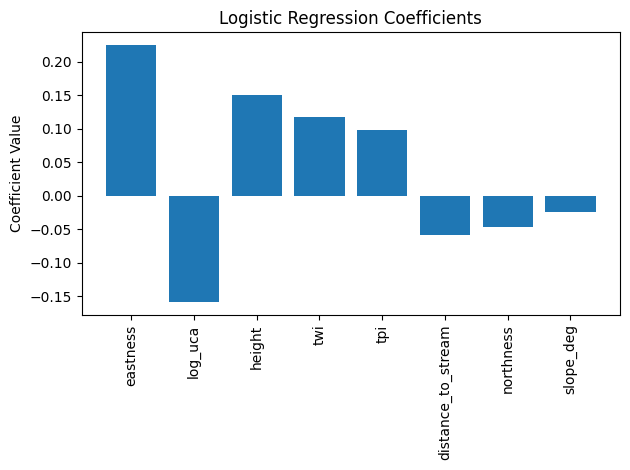

In [13]:
features_coef = list(X.columns)
coefficients = np.ravel(logistic_model.coef_)

sorted_idx = np.argsort(np.abs(coefficients))[::-1]

features_sorted = np.array(features_coef)[sorted_idx]
coefficients_sorted = coefficients[sorted_idx]

plt.figure()
plt.bar(features_sorted, coefficients_sorted)

plt.xticks(rotation=90)
plt.ylabel("Coefficient Value")
plt.title("Logistic Regression Coefficients")

plt.tight_layout()
plt.show()

In [14]:
proba = logistic_model.predict_proba(X_norm)
log_likelihood = np.sum(np.log(proba[np.arange(len(y)), y - 1]))

class_probs = np.array([np.mean(y == c) for c in [1, 2, 3]])
log_likelihood_null = np.sum(np.log(class_probs[y - 1]))

mcFadden_r2_score = 1 - (log_likelihood/log_likelihood_null)
mcFadden_r2_score

np.float64(0.00664752320506834)

As the logistic regression is only around 0.7% better than a model, that just predicts the overall class_probability, there is another indication that topography is not the major driver for forest degradation.  
However it still is interesting that this model considers eastness as the best feature to distinguish degraded from healthy, which could be due to the sun exposure during the afternoon and thus the hottest hours of a day. Log_UCA being negatively correlated is also quite reasonable, as areas with less water intuitively have a higher chance of degradation. Interestingly, TWI shows a positive coefficient, meaning higher soil moisture is associated with increased degradation probability, contrary to what log_UCA suggests. This contradiction may reflect interactions between correlated water-related features.


## Conclusion
This analysis investigated whether topographic features are associated with the forest degradation patterns identified through clustering. The results consistently indicate a weak but measurable relationship: northness and eastness show the strongest associations (ε² = 0.051 and 0.006 respectively), while the ordinal logistic regression explains only ~0.7% of variance beyond a null model (McFadden R² = 0.007).
The spatial concentration of degradation around specific ridges and a particular elevation band (~920m) suggests that geographic position matters more than topography alone. The dominant drivers of degradation likely lie elsewhere, which is a question explored further in the accompanying website post on [here](https://www.peer-schlieker.de/projects/forest-health-analysis).